<a href="https://colab.research.google.com/github/jansoe/public-covid-xr-data/blob/main/DatasetUsageAnaysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of dataset usage
### Creates Figure 3 and Figure 4 of the manuscript

#### Imports and authorization

In [1]:
import pandas as pd
import numpy as np

from collections import Counter
from pprint import pprint

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
import gspread
from oauth2client.client import GoogleCredentials

## Load PRISMA spreadsheet

### load PubMed Screening

In [4]:
gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open('DatasetScraping').worksheet('PubmedPaper')

rows = worksheet.get_all_values()
paper = pd.DataFrame.from_records(rows[1:], columns=rows[0])

Load manually assigned month where the scraping failed

In [5]:
m = paper.month == '0'
paper.loc[m, 'month'] = paper.loc[m, 'month_manual'].astype('int')
paper.month = paper.month.astype('int')
paper.year = paper.year.astype('int')

In [6]:
assert (paper.month == 0).sum() == 0, 'Not all month properly assigned'

### load *Google Dataset Search* resutls

In [7]:
gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open('DatasetScraping').worksheet('GoogleDataset')

rows = worksheet.get_all_values()
datasets_google = pd.DataFrame.from_records(rows[1:], columns=rows[0])

datasets_google = datasets_google[datasets_google.screening == '']
datasets_google = datasets_google.groupby('Link').agg({'eligibility': 'first'}).reset_index()

# Extract toplevel domain
datasets_google['domain'] = datasets_google.Link.apply(lambda x: '.'.join(x.split('://')[-1].split('/')[0].split('.')[-2:]))
datasets_google.eligibility = datasets_google.eligibility.replace({'': 'eligible'})

### load paper identified datasets

In [8]:
worksheet = gc.open('DatasetScraping').worksheet('PaperIdentifiedDatasets')

rows = worksheet.get_all_values()
datasets = pd.DataFrame.from_records(rows[1:], columns=rows[0]).rename(columns={'origin': 'link'})
datasets = datasets.set_index('name')
datasets.eligibility = datasets.eligibility.replace({'': 'eligible', 'noinfo': 'no_info'})

# Extract toplevel domain
datasets['domain'] = datasets.link.apply(
    lambda x: '.'.join(
        x.split('://')[-1].split('/')[0]
        .replace('co.uk', 'co::uk')
        .replace('or.jp', 'or::jp')
        .split('.')[-2:])
    .replace('::', '.')
)

display(datasets.head(2))

,eligibility,paper_name,link,domain
name,,,,
cohen,casecollection,Cohen/IEEE8023,https://github.com/ieee8023/covid-chestxray-da...,github.com
mooney,nocovid,Guangzhou pediatric,https://www.kaggle.com/paultimothymooney/chest...,kaggle.com


#### Include reannotations
We include reannotations if they are not based on a remix

In [41]:
datasets.eligibility = (
    datasets.eligibility
    .replace('remix_reannotation', 'remix')
    .replace('reannotation', 'eligible')
)
datasets.eligibility.value_counts()

remix             25
nocovid           15
casecollection    11
eligible           9
no_info            2
                   2
Name: eligibility, dtype: int64

## Eligibility by dataset source (Figure 3)

Dataset by search method

In [42]:
eligibility = pd.concat([
    datasets_google.eligibility.value_counts(),
    datasets.eligibility.value_counts()
], axis=1).fillna(0)
eligibility.columns = ['Direct search', 'Indicrect search']

In [47]:
order = ['eligible', 'casecollection', 'remix', 'no_meta', 'no_info', 'synthetic', 'nocovid']

Dataset by top level domain

In [48]:
google_by_source = (datasets_google
    .groupby('domain')
    .eligibility.value_counts()
    .unstack('eligibility')
    .reindex(columns=order)
    .fillna(0).astype('int')
)


paper_by_source = (datasets
    .groupby('domain')
    .eligibility.value_counts()
    .unstack('eligibility')
    .reindex(columns=order)
    .fillna(0).astype('int')
)

In [49]:
def main_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel('# datasets')
    ax.set_xlabel(None)
    #ax.set_ylim([0, 110])
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')

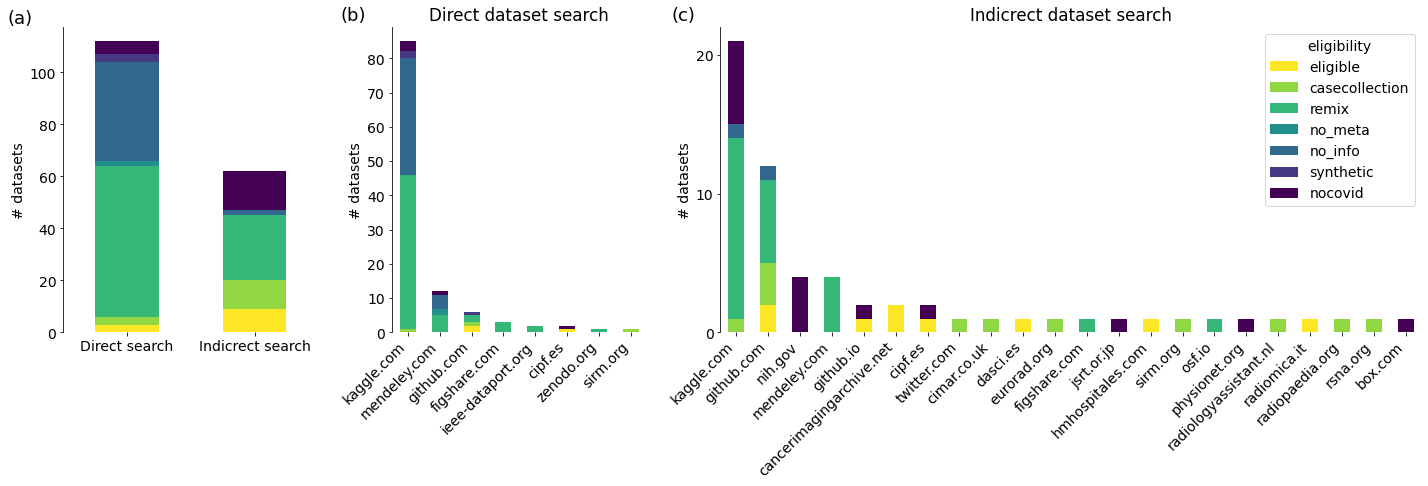

In [50]:
cmap = 'viridis_r' #, 'plasma_r'

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, figsize=(20,7), gridspec_kw={'width_ratios': [8, 8, 22]})

eligibility.reindex(order).T.plot.bar(stacked=True, cmap=cmap, ax = axes[0], legend=False)
to_plot = google_by_source.iloc[np.argsort(google_by_source.sum(1))[::-1]]
to_plot.plot.bar(stacked=True, cmap=cmap, ax = axes[1], legend=False)

to_plot = paper_by_source.iloc[np.argsort(paper_by_source.sum(1))[::-1]]
to_plot.plot.bar(stacked=True, cmap=cmap, ax = axes[2])

for ax in axes:
    main_format(ax)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation = 0, ha='center')
axes[0].text(-.22, 1.01, '(a)', transform=axes[0].transAxes, size=18) #, weight='bold')

axes[1].set_title('Direct dataset search')
axes[1].text(-.2, 1.02, '(b)', transform=axes[1].transAxes, size=18) #, weight='bold')

axes[2].set_title('Indicrect dataset search')
axes[2].set_yticks([0, 10, 20])
axes[2].text(-.07, 1.02, '(c)', transform=axes[2].transAxes, size=18) # , weight='bold')

plt.tight_layout()
fig.savefig('idenification.png', dpi=300, bbox_inches='tight')

## Dataset usage on PubMed

In [51]:
selected_paper = paper[paper.relevant == ''].copy()

In [52]:
selected_paper.groupby('term').doi.count().sort_values(ascending=False)

term
covid AND x-ray AND dataset             101
covid AND x-ray AND deep learning        49
covid AND x-ray AND machine learning     42
covid AND x-ray AND data set             10
Name: doi, dtype: int64

#### Annotate each paper if it at least uses one dataset of a specific eligibility category 

In [53]:
def extract_and_cat(ds_list):
    ds = [d for d in ds_list.split(', ') if len(d)>0]
    ds = ['private' if 'privat' in d else d for d in ds]
    ds = [datasets.loc[d, 'eligibility'] if d in datasets.index else d for d in ds]
    return list(set(ds))


selected_paper['category'] = selected_paper['extracted datasets'].apply(extract_and_cat)
selected_paper.head(2)

,doi,doi_link,year,month,month_manual,title,relevant,extracted datasets,term,category
1,10.3233/XST-200715,https://doi.org/10.3233/XST-200715,2020,5,5,Identification of COVID-19 samples from chest ...,,"cohen, mooney",covid AND x-ray AND dataset,"[casecollection, nocovid]"
2,10.3233/XST-200720,https://doi.org/10.3233/XST-200720,2020,9,9,Detection of coronavirus disease from X-ray im...,,"cohen, mooney",covid AND x-ray AND dataset,"[casecollection, nocovid]"


#### Dataset references per month

In [54]:
def extract_and_map(ds_list):
    ''' convert a list of dataset strings into a list of datasets
        do some datacleaning on the fly (map all datasetnames which contain "privat" to private)
    '''
    datasets = sum([i.split(', ') for i in ds_list], [])
    datasets = [d for d in datasets if len(d)>0]
    datasets = ['private' if 'privat' in d else d for d in datasets]
    return datasets

In [55]:
freq = selected_paper.groupby(['year', 'month']).agg({
    'doi': 'count',
    'extracted datasets': lambda x: Counter(extract_and_map(x))
})

freq = freq['extracted datasets'].apply(pd.Series).fillna(0)
display(freq.head(2))

cohen  mooney  ...  brixia  mendeley_extensive
year month                 ...                            
2020 4        3.0     2.0  ...     0.0                 0.0
     5       13.0     7.0  ...     0.0                 0.0

[2 rows x 53 columns]

In [56]:
# usage order
counts = freq.sum(axis=0)
ordered = counts.sort_values().index[::-1]

#### Lump all dataset with less than X references into "other" category

Define what to lump ...

In [57]:
keep_seperate_thres = 5

aggregation_map = {}
for id, count in counts.iteritems():
    if count < keep_seperate_thres:
        corresponding_cat = datasets.loc[id, 'eligibility']
        if (len(corresponding_cat) > 0) and corresponding_cat != 'eligible':
            k = 'other_' + datasets.loc[id, 'eligibility']
            agg_list  = aggregation_map.setdefault(k, [])
            agg_list.append(id)

print('Datasets are aggregated as follows: \n')
pprint(aggregation_map)

Datasets are aggregated as follows: 

{'other_casecollection': ['rsna_web',
                          'github_ncbi-nlp',
                          'radiology_assitant_web',
                          'eurorad'],
 'other_no_info': ['kaggle_nabeelsajid917', 'github_smfai200'],
 'other_nocovid': ['kaggle_ahmedali2019',
                   'jsrt',
                   'shenzen',
                   'mimic-cxr',
                   'padchest',
                   'kaggle_mader',
                   'kaggle_digitalpathology',
                   'openi'],
 'other_remix': ['kaggle_coronahack',
                 'github_muhammedtalo',
                 'kaagle_khoongweihao',
                 'argentinia',
                 'kaggle_darshan1504',
                 'kaggle_amanullahasraf',
                 'mendeley_augmented',
                 'mendeley_combined',
                 'github_cxnet',
                 'figshare_bejing',
                 'kaggle_masumrefat',
                 'kaggle_rupeshs',
    

... and lump

In [58]:
freq_short = freq.copy().loc[:, freq.sum(0).sort_values().index[::-1]]
for k, v in aggregation_map.items():
    freq_short[k] = freq_short[v].sum(1)
    freq_short = freq_short.drop(columns=v)
freq_short = freq_short.T
display(freq_short.head(2))

year   2020                                              2021            
month    4     5    6    7    8     9     10    11   12    1     2     3 
cohen   3.0  13.0  5.0  8.0  8.0  16.0  10.0  16.0  6.0  16.0  16.0  19.0
mooney  2.0   7.0  5.0  1.0  2.0  12.0   5.0   7.0  4.0  12.0   8.0   7.0

Map dataset names to those finally used in the paper and add eligibility category as additional index

In [59]:
index = pd.MultiIndex.from_arrays([
    # category assignment
    [datasets.loc[i, 'eligibility'] 
      if i in datasets.index else i.replace('other_' , '') 
      for i in freq_short.index],
     # paper name mapping
     [datasets.loc[i, 'paper_name'] 
      if ((i in datasets.index) and len(datasets.loc[i, 'paper_name'])) else i
      for i in freq_short.index]
])

freq_short = freq_short.set_index(index)
display(freq_short.head(2))

year                               2020                  ...       2021            
month                                4     5    6    7   ...   12    1     2     3 
casecollection Cohen/IEEE8023       3.0  13.0  5.0  8.0  ...  6.0  16.0  16.0  19.0
nocovid        Guangzhou pediatric  2.0   7.0  5.0  1.0  ...  4.0  12.0   8.0   7.0

[2 rows x 12 columns]

### Sum dataset usage across all month
Reorder by eligibiity category as defined

In [60]:
order2 = ['eligible', 'casecollection', 'remix',  'nocovid', 'no_info',  'private', 'not_identified']

total_usage = pd.DataFrame(freq_short.reindex(order2, level=0).sum(1)).rename(columns={0:'papers_referencing_dataset'})
total_usage.head(2)

papers_referencing_dataset
eligible ACTUALMED                            11.0
         BIMCV-COVID19                         3.0

### Extract paper dataset usage by eligibility category

In [61]:
category_usage_by_time = pd.DataFrame(
    selected_paper.groupby(['year', 'month'])
    .category.agg(lambda x: {k: v for k,v in Counter(sum(x, [])).most_common()})
    .apply(pd.Series).fillna(0)
    .T
)

category_usage = pd.DataFrame(category_usage_by_time.sum(1))
category_usage.columns = ['papers_referencing_dataset']
category_usage.head(2)

,papers_referencing_dataset
casecollection,142.0
nocovid,122.0


### Interleave eligibility category usage and dataset usage tables

In [62]:
total_usage['order'] = np.arange(0.5, len(total_usage))
category_order = total_usage.reset_index().groupby('level_0').order.first() - 0.5

category_usage['order'] = category_order

multiindex = pd.MultiIndex.from_arrays([
    category_usage_by_time.index, 
    ['any ' + x for x in category_usage_by_time.index]
]) 

category_usage_by_time.index = multiindex
category_usage.index = multiindex

In [63]:
full_usage = pd.concat([total_usage, category_usage]).sort_values(by='order')
full_usage = full_usage.drop(index = [('not_identified', 'not_identified'), ('private', 'private'), ('no_info', 'other_no_info')])
full_usage['is_cat'] = full_usage.order.astype('int') == full_usage.order

In [64]:
full_usage_temporal = pd.concat([freq_short, category_usage_by_time]).reindex(full_usage.index)

In [65]:
full_usage.head(2)

papers_referencing_dataset  order  is_cat
eligible any eligible                        19.0    0.0    True
         ACTUALMED                           11.0    0.5   False

## Dataset usage Viz (Figure 4) 

In [66]:
import seaborn as sns

In [68]:
# Reuse colors from Figure 3
color_values = {j: i/6 for i, j in enumerate(order)}
color_values['private'] = 2.5/6
color_values['not_identified'] = 5.5/6

full_usage['colors'] = [
    getattr(plt.cm, cmap)(color_values[i])
    for i in full_usage.index.get_level_values(0)

]

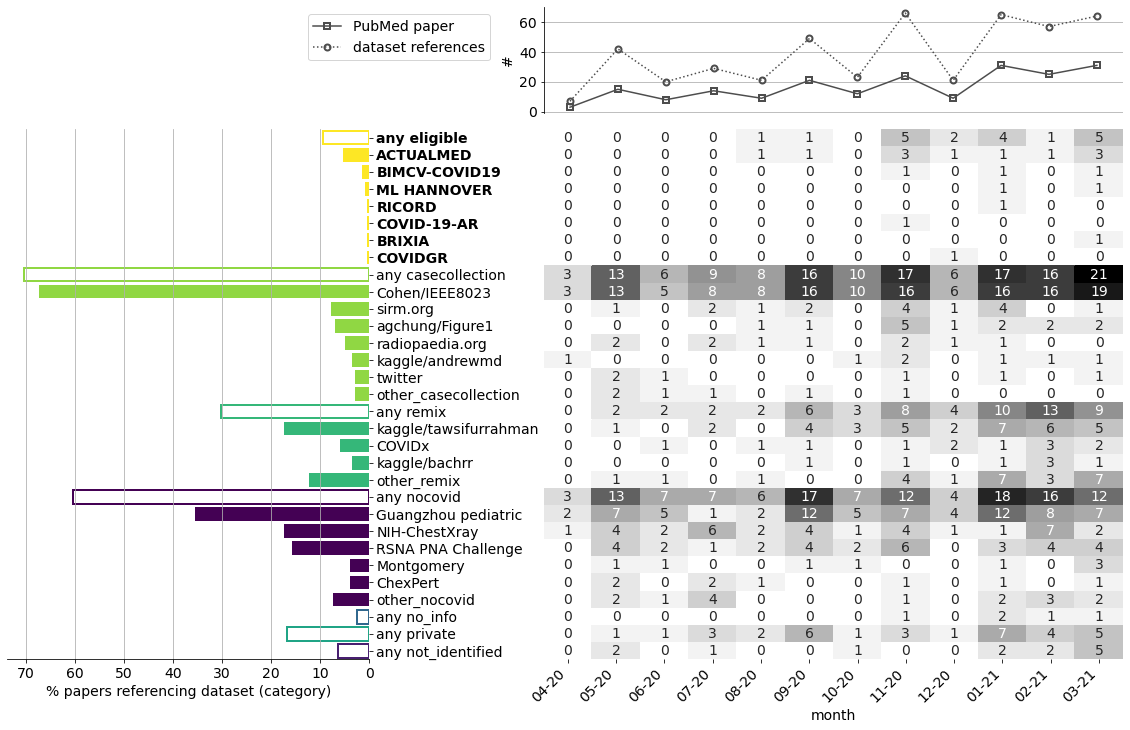

In [69]:
fig, axes = plt.subplots(2,2, figsize=(20,12),  
    gridspec_kw = {
        'wspace': 0.37,
        'hspace': 0.05,
        'width_ratios': [5, 8],
        'height_ratios': [2, 10]
        }
    )

index = full_usage.is_cat.values
axes[1,0].barh(
    np.arange(len(full_usage))[::-1][~index],
    full_usage.papers_referencing_dataset[~index]/len(selected_paper)*100,
    color = full_usage.colors[~index]
)
axes[1,0].barh(
    np.arange(len(full_usage))[::-1][index],
    full_usage.papers_referencing_dataset[index]/len(selected_paper)*100,
    edgecolor = full_usage.colors[index],
    facecolor='None',
    linewidth = 2
)


axes[1,0].set_xlim(axes[1, 0].get_xlim()[::-1])
axes[1,0].set_xlabel('% papers referencing dataset (category)')
#axes[1].spines['right'].set_visible(False)
axes[1,0].spines['right'].set_visible(False)
axes[1,0].spines['top'].set_visible(False)
axes[1,0].spines['left'].set_visible(False)
axes[1,0].yaxis.tick_right()
#relevant_y = [j for j, i in enumerate(usage.papers_referencing_category[::-1]) if i]
axes[1,0].set_yticks(np.arange(len(full_usage)))
_ = axes[1,0].set_yticklabels(full_usage.index.get_level_values(1)[::-1])
axes[1,0].xaxis.grid(True)
axes[1,0].set_ylim([-0.5, len(full_usage)-0.5])

o = sns.heatmap(full_usage_temporal, ax= axes[1,1], annot=True, cmap='gray_r', cbar=False)
axes[1,1].set_yticks([])
axes[1,1].set_ylabel('')
#axes[1,1].xaxis.tick_top()
axes[1,1].yaxis.grid(True)
axes[1,1].set_xticklabels(['{m:02d}-{y}'.format(m=m, y=str(y)[2:]) for y, m in full_usage_temporal.columns], rotation='45', ha='right')
axes[1,1].set_xlabel('month')

axes[0,0].axis('off')
#axes[0,2].axis('off')


axes[0,1].plot(
    #full_usage_temporal[~full_usage.is_cat.values].sum().T.values,
    selected_paper.groupby(['year', 'month']).month.count().values,
    's-', mfc='none', mew=2, color='0.3', label='PubMed paper'
)
axes[0,1].plot(
    full_usage_temporal[~full_usage.is_cat.values].sum().T.values,
    'o:', mfc='none', mew=2, color='0.3', label='dataset references'
)
axes[0,1].spines['right'].set_visible(False)
axes[0,1].spines['top'].set_visible(False)
axes[0,1].spines['bottom'].set_visible(False)
axes[0,1].set_xticks([])
axes[0,1].yaxis.grid(True)


axes[0,1].set_yticks([0, 20, 40, 60])
#axes[0,1].set_ylabel('referenced\ndatasets')

#axes[0,1].set_yticks([5, 15, 25, 35])
axes[0,1].set_ylabel('#')
axes[0,1].set_ylim([-1, 70])
axes[0,1].legend(bbox_to_anchor=(-0.08, 1), loc='upper right')

for i in range(1, 9):
    axes[1,0].get_yticklabels()[-i].set_weight("bold")

fig.savefig('usagepattern.png', dpi=300)

In [72]:
full_usage.papers_referencing_dataset/len(selected_paper)*100

eligible        any eligible              9.405941
                ACTUALMED                 5.445545
                BIMCV-COVID19             1.485149
                ML HANNOVER               0.990099
                RICORD                    0.495050
                COVID-19-AR               0.495050
                BRIXIA                    0.495050
                COVIDGR                   0.495050
casecollection  any casecollection       70.297030
                Cohen/IEEE8023           67.326733
                sirm.org                  7.920792
                agchung/Figure1           6.930693
                radiopaedia.org           4.950495
                kaggle/andrewmd           3.465347
                twitter                   2.970297
                other_casecollection      2.970297
remix           any remix                30.198020
                kaggle/tawsifurrahman    17.326733
                COVIDx                    5.940594
                kaggle/bachrr  